In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

imdb_score_binned
2    1839
3     777
1     235
4     129
0      24
Name: count, dtype: int64


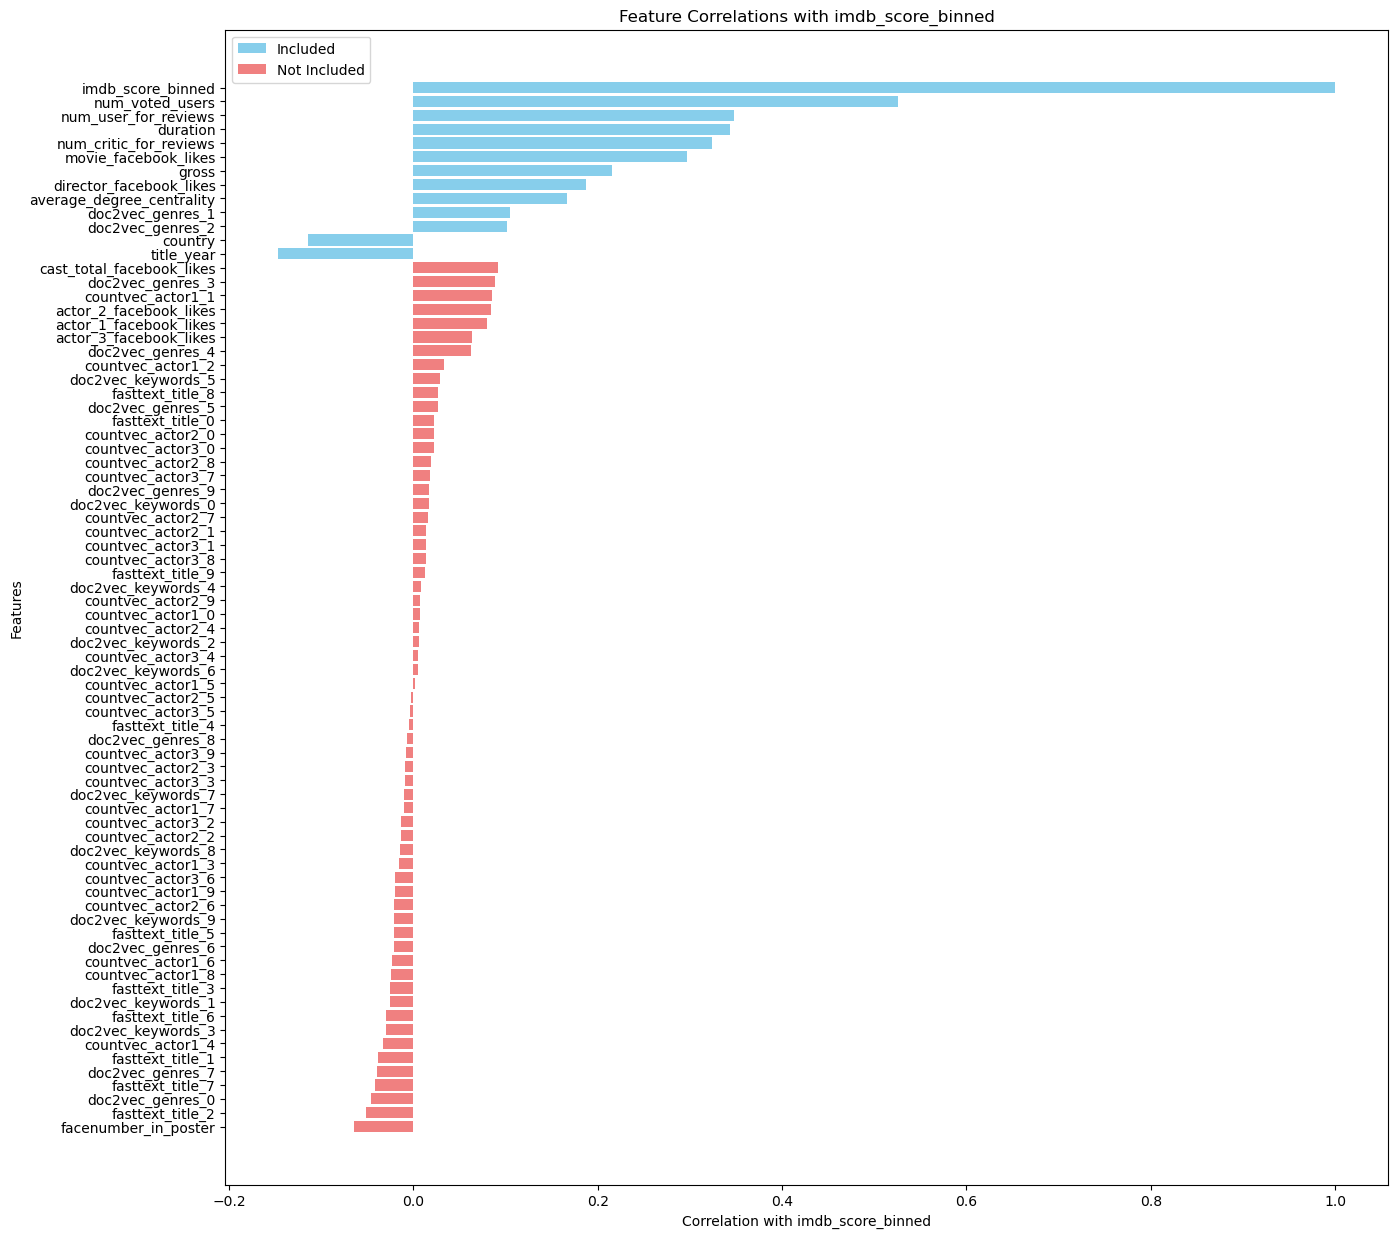

In [7]:
# Load in data
train_data = pd.read_csv('train_dataset.csv')
test_data = pd.read_csv('test_dataset.csv')

# Exhibit class distribution
class_counts = train_data['imdb_score_binned'].value_counts()
print(class_counts)

# Load in Doc2Vec genre feature
train_D2V_genres = np.load('train_doc2vec_features_genre.npy')
test_D2V_genres = np.load('test_doc2vec_features_genre.npy')
pca = PCA(n_components = 10)
pca.fit(train_D2V_genres)
reduced_train_D2V_genres = pca.transform(train_D2V_genres)
reduced_test_D2V_genres = pca.transform(test_D2V_genres)

reduced_train_D2V_genres_df = pd.DataFrame(reduced_train_D2V_genres, columns=[f"doc2vec_genres_{i}" for i in range(reduced_train_D2V_genres.shape[1])])
reduced_test_D2V_genres_df = pd.DataFrame(reduced_test_D2V_genres, columns=[f"doc2vec_genres_{i}" for i in range(reduced_test_D2V_genres.shape[1])])

# Load in Doc2Vec keywords feature
train_D2V_keywords = np.load('train_doc2vec_features_plot_keywords.npy')
pca = PCA(n_components = 10)
pca.fit(train_D2V_keywords)
reduced_train_D2V_keywords = pca.transform(train_D2V_keywords)

reduced_train_D2V_keywords_df = pd.DataFrame(reduced_train_D2V_keywords, columns=[f"doc2vec_keywords_{i}" for i in range(reduced_train_D2V_keywords.shape[1])])

# Load in fasttext title feature
train_FT_title = np.load('train_fasttext_title_embeddings.npy')
pca = PCA(n_components = 10)
pca.fit(train_FT_title)
reduced_train_FT_title = pca.transform(train_FT_title)

reduced_train_FT_title_df = pd.DataFrame(reduced_train_FT_title, columns=[f"fasttext_title_{i}" for i in range(reduced_train_FT_title.shape[1])])

# Load in countvec actor 1 feature
train_CV_actor1 = np.load('train_countvec_features_actor_1_name.npy')
pca = PCA(n_components = 10)
pca.fit(train_CV_actor1)
reduced_CV_actor1 = pca.transform(train_CV_actor1)

reduced_CV_actor1_df = pd.DataFrame(reduced_CV_actor1, columns=[f"countvec_actor1_{i}" for i in range(reduced_CV_actor1.shape[1])])

# Load in countvec actor 2 feature
train_CV_actor2 = np.load('train_countvec_features_actor_2_name.npy')
pca = PCA(n_components = 10)
pca.fit(train_CV_actor2)
reduced_train_CV_actor2 = pca.transform(train_CV_actor2)

reduced_CV_actor2_df = pd.DataFrame(reduced_train_CV_actor2, columns=[f"countvec_actor2_{i}" for i in range(reduced_train_CV_actor2.shape[1])])

# Load in countvec actor 2 feature
train_CV_actor3 = np.load('train_countvec_features_actor_2_name.npy')
pca = PCA(n_components = 10)
pca.fit(train_CV_actor3)
reduced_train_CV_actor3 = pca.transform(train_CV_actor3)

reduced_CV_actor3_df = pd.DataFrame(reduced_train_CV_actor3, columns=[f"countvec_actor3_{i}" for i in range(reduced_train_CV_actor3.shape[1])])


# Save id column for later Kaggle submission
id_col = test_data['id']
train_data = train_data.drop(['id'], axis=1)
test_data = test_data.drop(['id'], axis=1)


# Replace top 3 rated countries with ordered values 
def map_country(country):
    if country in high_rated_countries:
        if country == 'USA':
            return 3
        elif country == 'UK':
            return 2
        else:
            return 1
    else:
        return 0

high_rated_countries = ['USA', 'UK', 'France']
train_data['country'] = train_data['country'].map(map_country)
test_data['country'] = test_data['country'].map(map_country)

filtered_df = train_data[train_data['imdb_score_binned'] >= 3]

country_counts = filtered_df['country'].value_counts()

# Get country counts data
# print(country_counts)


# Remove missing values
train_data.dropna(axis=0, inplace=True)

# Split into attributes and labels

attributes = train_data.iloc[:, :-1]
numeric_attributes = attributes.select_dtypes(include='number')
label = train_data.iloc[:, -1]

# Concatenate genre D2V to X and test data 
combined_train = pd.concat([numeric_attributes, reduced_train_D2V_genres_df, reduced_train_D2V_keywords_df, reduced_train_FT_title_df, reduced_CV_actor1_df, reduced_CV_actor2_df, reduced_CV_actor3_df, reduced_train_D2V_genres_df, label], axis=1)
combined_train.dropna(axis=0, inplace=True)
test_data = pd.concat([test_data, reduced_test_D2V_genres_df], axis=1)

# Split combined data into X and y
X = combined_train.iloc[:, :-1]
y = combined_train.iloc[:, -1]

# Drop categorical/nominal data

corr_matrix = combined_train.corr()
corr_with_label = corr_matrix['imdb_score_binned'].sort_values(ascending=False)
corr_columns = corr_matrix.columns[abs(corr_matrix['imdb_score_binned']) > 0.1]
corr_columns = corr_columns.drop('imdb_score_binned')

# Separate features based on the threshold 0.1 using absolute values
threshold = 0.1

# Plotting the horizontal bar graph
plt.figure(figsize=(15, 15))

# Plot included features
included_sorted = corr_with_label[abs(corr_with_label) >= threshold]
plt.barh(included_sorted.index, included_sorted.values, color='skyblue', label='Included')

# Plot not included features
not_included_sorted = corr_with_label[abs(corr_with_label) < threshold]
plt.barh(not_included_sorted.index, not_included_sorted.values, color='lightcoral', label='Not Included')

plt.xlabel('Correlation with imdb_score_binned')
plt.ylabel('Features')
plt.title('Feature Correlations with imdb_score_binned')
plt.legend()
plt.gca().invert_yaxis()
plt.show()

X = X[corr_columns]
test_data = test_data[corr_columns]